# Benchmark models
This notebook benchmarks the performance of the ResNet18, ResNet50, AlexNet and EfficientNet models, trained on our dataset.
This is accomplished using the pytorch benchmark library.
There is a known error, when you train all models, python loads all the base models into memory which is more than the 15GiB available on the GPU.

### Load the models

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import yaml
import datetime
from pytorch_benchmark import benchmark # benchmarking library

from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights

In [3]:
## Load the models
def load_model(model_name, directory="models"):
    # Initiate pretrained model
    if model_name == "resnet18":
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == "resnet50":
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 2)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
    else:
        raise ValueError("Invalid model name")
    
    # Load the trained model weights
    model.load_state_dict(torch.load(os.path.join(directory, f"{model_name}_model.pt"), weights_only=True))

    # link the model to the CPU or CUDA
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return (model, device)

## Benchmark models

In [3]:
def benchmark_model(model_name):
    (model, _) = load_model(model_name)
    sample = torch.randn(2, 3, 224, 224)  # (B, C, H, W)
    results = benchmark(
        model=model,
        sample=sample,
        num_runs=1000,
        batch_size=8,
        print_details=True
    )
    for prop in {"device", "flops", "params", "timing"}:
        assert prop in results
    return yaml.dump(results)

model_names = ["resnet18", "resnet50", "alexnet", "efficientnet"]
for model_name in model_names:
    print(f"Benchmarking {model_name.capitalize()} model")
    result = benchmark_model(model_name)
    # Save the results, create a new file if it doesn't exist
    with open(f"./benchmarks/{model_name}_benchmark.yaml", "w") as file:
        file.write(result)

Benchmarking Efficientnet model


Warming up with batch_size=1: 100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


Warning! No positional inputs found for a module, assuming batch size is 1.
EfficientNet(
  4.01 M, 100.000% Params, 400.39 MMac, 100.000% MACs, 
  (features): Sequential(
    4.01 M, 99.936% Params, 400.33 MMac, 99.984% MACs, 
    (0): Conv2dNormActivation(
      928, 0.023% Params, 11.64 MMac, 2.907% MACs, 
      (0): Conv2d(864, 0.022% Params, 10.84 MMac, 2.707% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, 0.002% Params, 802.82 KMac, 0.201% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(0, 0.000% Params, 0.0 Mac, 0.000% MACs, inplace=True)
    )
    (1): Sequential(
      1.45 k, 0.036% Params, 11.64 MMac, 2.908% MACs, 
      (0): MBConv(
        1.45 k, 0.036% Params, 11.64 MMac, 2.908% MACs, 
        (block): Sequential(
          1.45 k, 0.036% Params, 11.64 MMac, 2.908% MACs, 
          (0): Conv2dNormActivation(
            352, 0.009% Params, 4.42 MMac, 1.103% MACs, 
          

Warming up with batch_size=1: 100%|██████████| 100/100 [00:00<00:00, 160.42it/s]
/home/jovyan/.local/lib/python3.8/site-packages/pytorch_benchmark/benchmark.py:112: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(
Measuring inference for batch_size=1: 100%|██████████| 1000/1000 [00:07<00:00, 125.69it/s]
Unable to measure energy consumption. Device must be a NVIDIA Jetson.
Measuring inference for batch_size=8: 100%|██████████| 1000/1000 [00:08<00:00, 122.65it/s]
Unable to measure energy consumption. Device must be a NVIDIA Jetson.


# Visualize the model
First load the datasets, then create the functions to show an image and visualize the model.
And the final codeblock actually visualizes the given model.

In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the data
data_dir = 'datasets/melanoma_dataset'
image_datasets = {kind: datasets.ImageFolder(os.path.join(data_dir, kind), data_transforms[kind]) for kind in ['train', 'val']}
dataloaders = {kind: torch.utils.data.DataLoader(image_datasets[kind], batch_size=4, shuffle=True, num_workers=4) for kind in ['train', 'val']}
dataset_sizes = {kind: len(image_datasets[kind]) for kind in ['train', 'val']}
class_names = image_datasets['train'].classes

# Use Cuda if available, otherwise use the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Data loaded on {device}")

# Test cell to visualize the training data.
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Data loaded on cuda:0


In [37]:
def visualize_model(model, device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

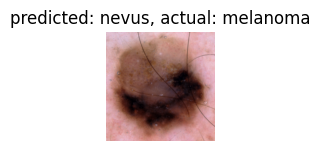

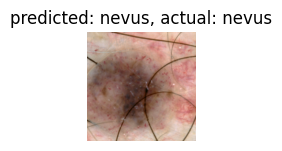

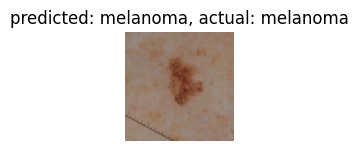

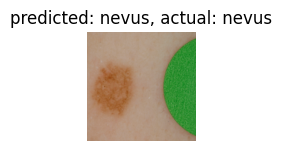

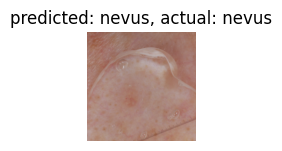

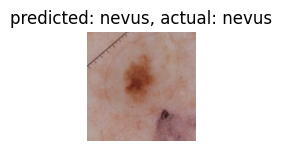

In [38]:
# Visualize the ResNet18 model
(model, device) = load_model("resnet18")
visualize_model(model, device)